In [88]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

# --- CONFIGURATION ---
DATA_DIR = "./data"
MANIFEST_FILE = os.path.join(DATA_DIR, "runs_manifest.csv")
SWEEPS_DIR = os.path.join(DATA_DIR, "sweeps")

In [68]:
# --- 1. LOAD MANIFEST (The Phonebook) ---
def load_manifest():
    """Loads the lightweight metadata index."""
    if not os.path.exists(MANIFEST_FILE):
        raise FileNotFoundError("Manifest not found! Run the downloader script first.")
    return pd.read_csv(MANIFEST_FILE)

# --- 2. FIND SWEEP ID (The Search Tool) ---
def find_sweep_id(manifest, search_term):
    """
    Helps you find the sweep_id based on a run name or config.
    Example: find_sweep_id(manifest, "polar_safety")
    """
    # Search in config keys
    matches = manifest[manifest.apply(lambda row: row.astype(str).str.contains(search_term).any(), axis=1)]

    if matches.empty:
        print(f"No sweeps found matching '{search_term}'")
        return None

    unique_sweeps = matches["sweep_id"].unique()
    print(f"Found {len(unique_sweeps)} matching sweeps:")
    for sw in unique_sweeps:
        # Get a sample run name to help identify it
        sample_name = matches[matches["sweep_id"] == sw].iloc[0]["run_name"]
        print(f"  - ID: {sw} (Sample Run: {sample_name})")

    return unique_sweeps[0] if len(unique_sweeps) == 1 else unique_sweeps

# --- 3. LOAD SWEEP DATA (The Heavy Lifter) ---
def load_sweep_data(sweep_id, manifest):
    """
    Loads the time-series data for ONE sweep and joins it with Hyperparameters.
    """
    filepath = os.path.join(SWEEPS_DIR, f"sweep_{sweep_id}.csv")

    print(f"Loading data for Sweep {sweep_id}...")
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File not found: {filepath}")

    # 1. Load History (Metrics over time)z
    df_history = pd.read_csv(filepath, low_memory=False)

    # 2. Prepare Metadata (Hyperparameters)
    # Filter manifest to just this sweep's runs to speed up merge
    sweep_meta = manifest[manifest["sweep_id"] == sweep_id].copy()

    # Select useful columns (Config + Identifiers)
    # We grab everything starting with 'config_'
    meta_cols = ["run_id", "run_name", "state"] + \
                [c for c in sweep_meta.columns if c.startswith("config_")]

    # 3. Merge (SQL-style Join)
    # history.run_id <-> manifest.run_id
    df_merged = pd.merge(df_history, sweep_meta[meta_cols], on="run_id", how="left")

    print(f"Loaded {len(df_merged)} rows. Columns: {len(df_merged.columns)}")
    return df_merged

# --- 4. THE FAST PLOTTER (Updated for Flattened Configs) ---
def plot_sweep(df, x, y, skip=0, hue=None, title=None, log_scale=False):
    plt.figure(figsize=(10, 6))

    for hue_val in df[hue].unique():
            
        group = df[df[hue] == hue_val].iloc[skip:]
    
        sns.lineplot(
            data=group,
            x=x,
            y=y,
            #hue=hue,
            errorbar="sd"
        )

    if log_scale:
        plt.yscale("log")

    clean_title = title if title else f"{y} vs {x}"
    plt.title(clean_title)
    plt.grid(True, alpha=0.3)
    plt.show()

In [3]:
# Load Metadata
manifest = load_manifest()

# Find the sweep where you tested "Safety Factor"
# This prints the ID you need (e.g., "5pllqyjx")
sweep_ids = find_sweep_id(manifest, "polar_safety")

Found 28 matching sweeps:
  - ID: 5pllqyjx (Sample Run: valiant-sweep-2)
  - ID: manual_runs (Sample Run: dashing-sweep-1)
  - ID: bbxdd87r (Sample Run: denim-sweep-1)
  - ID: bfj88tht (Sample Run: solar-sweep-2)
  - ID: j7qzf95f (Sample Run: logical-sweep-1)
  - ID: t8splz5x (Sample Run: legendary-sweep-3)
  - ID: k1b5yfbn (Sample Run: sandy-sweep-1)
  - ID: rb2rgyx9 (Sample Run: cosmic-sweep-1)
  - ID: pxrm9xt8 (Sample Run: smooth-sweep-4)
  - ID: u7hh6wc8 (Sample Run: bright-sweep-3)
  - ID: ulrdsxlx (Sample Run: lucky-sweep-2)
  - ID: 05cfprpx (Sample Run: avid-sweep-2)
  - ID: hkw05gba (Sample Run: skilled-sweep-5)
  - ID: qmzevjll (Sample Run: crimson-sweep-4)
  - ID: lh2tzeh1 (Sample Run: rich-sweep-1)
  - ID: eifb7cyl (Sample Run: solar-sweep-1)
  - ID: lyncbpdx (Sample Run: clean-sweep-4)
  - ID: 25cht4go (Sample Run: proud-sweep-4)
  - ID: t5adqjx0 (Sample Run: vocal-sweep-5)
  - ID: crvl272m (Sample Run: upbeat-sweep-1)
  - ID: d4c0fgt9 (Sample Run: swift-sweep-2)
  - ID: rs

In [447]:
df = load_sweep_data("5pllqyjx", manifest)
df["step_norm"] = df["_step"] / df["_step"].max()
# for val in df['config_optimizer_params.args.polar_safety'].unique():
#     print(val)
for col in df.columns:
    print(col)
# x = 'diag_log_step'
# y = 'svd/layer11_q/condition_number'
# x_cols = df.columns.str.contains(x)
# print("Found x Columns:")
# for col in df.columns[x_cols]:
#     print("\t", col)

# y_cols = df.columns.str.contains(y)
# print("Found y Columns:")
# for col in df.columns[y_cols]:
#     print("\t", col)

# assert sum(x_cols) == 1, "invalid number of columns found for x"
# assert sum(y_cols) == 1, "invalid number of columns found for y"

Loading data for Sweep 5pllqyjx...
Loaded 1464 rows. Columns: 220
svd/layer11_v/sigma_min
svd/update_layer11_k/sigma_min
ortho/layer0_q/err_normalized
svd/update_layer11_q/effective_rank
svd/update_layer5_k/condition_number
svd/update_layer11_stacked/condition_number
svd/update_layer0_v/effective_rank
svd/layer5_v/sigma_max
attn/layer5/entropy/p05
svd/layer0_v/sigma_max
svd/layer0_q/spectral_gap
svd/layer5_q/sigma_max
svd/layer11_q/condition_number
svd/update_layer11_q/sigma_max
svd/layer11_q/sigma_max
svd/update_layer5_v/spectral_gap
weights/layer5_attn_norm
svd/layer11_k/effective_rank
svd/update_layer11_k/sigma_max
weights/layer0_attn_norm
logits/layer5/max_p95
svd/layer0_v/sigma_min
svd/update_layer11_q/sigma_min
svd/layer5_v/effective_rank
svd/update_layer0_q/effective_rank
svd/update_layer5_stacked/spectral_gap
logits/layer0/max_p95
svd/update_layer0_stacked/sigma_max
train/loss
svd/update_layer11_q/condition_number
svd/layer5_v/spectral_gap
svd/update_layer11_stacked/effective_r

In [448]:
def plot_data(df, x, y_list, title_list, hue, start=0, end=1000, \
              use_ci=False, log_scale=False, plot_med=True, save_plot=False):

    fig, axes = plt.subplots(1, len(y_list), figsize=(15, 4))
    plt.subplots_adjust(wspace=0.28)
    
    for plt_idx, y in enumerate(y_list):
        
        if x != "_step":
            x_cols = df.columns.str.contains(x)
            print("Found x Columns:")
            for col in df.columns[x_cols]:
                print(col)
            assert sum(x_cols) == 1, "invalid number of columns found for x"
        
        y_cols = df.columns.str.contains(y)
        print("Found y Columns:")
        for col in df.columns[y_cols]:
            print(col)
        assert sum(y_cols) == 1, "invalid number of columns found for y"
    
        print("Plotting Data...")
        sns.set_style("whitegrid")
        for val in df[hue].unique():
            df_grouped = df[df[hue] == val]
            df_clipped = df_grouped[(start <= df_grouped[x]) & (df_grouped[x] <= end)]
            ax_i = sns.lineplot(
                data=df_clipped,
                x=x,
                y=y,
                errorbar="sd",
                linestyle="-",
                linewidth=1,
                alpha=1,
                ax=axes[plt_idx],
                label=val if plt_idx == 0 else None
            )
    
            if log_scale:
                axes[plt_idx].set_yscale("log")

            axes[plt_idx].set_title(title_list[plt_idx], fontsize=14)
            axes[plt_idx].set_xlabel("Epoch", fontsize=12)
            axes[plt_idx].set_ylabel("Condition Number (Log Scale)", fontsize=12)
    
    fig.suptitle("Safety Factor: Condition Number", y=1.19, fontsize=16)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        title="Safety Factor",
        loc="upper center",
        ncol=len(labels),
        bbox_to_anchor=(0.5, 1.12),
        title_fontsize=12,
        fontsize=11,
    )

    EPS = 1e-8
    ymin = max(EPS, min(ax.get_ylim()[0] for ax in axes))
    ymax = max(ax.get_ylim()[1] for ax in axes)

    for ax in axes:
        ax.set_ylim(ymin, ymax)
        ax.tick_params(axis='both', labelsize=10)
        if ax.get_legend() is not None:
            ax.legend_.remove()
    
    if save_plot:
        print("Plot Saved.")
        plt.savefig(f"./plots/safety_factor_condition_number.jpg", bbox_inches='tight')
    
    plt.show();

Found x Columns:
step_norm
Found y Columns:
svd/update_layer0_stacked/condition_number
Plotting Data...
Found x Columns:
step_norm
Found y Columns:
svd/update_layer5_stacked/condition_number
Plotting Data...
Found x Columns:
step_norm
Found y Columns:
svd/update_layer11_stacked/condition_number
Plotting Data...
Plot Saved.


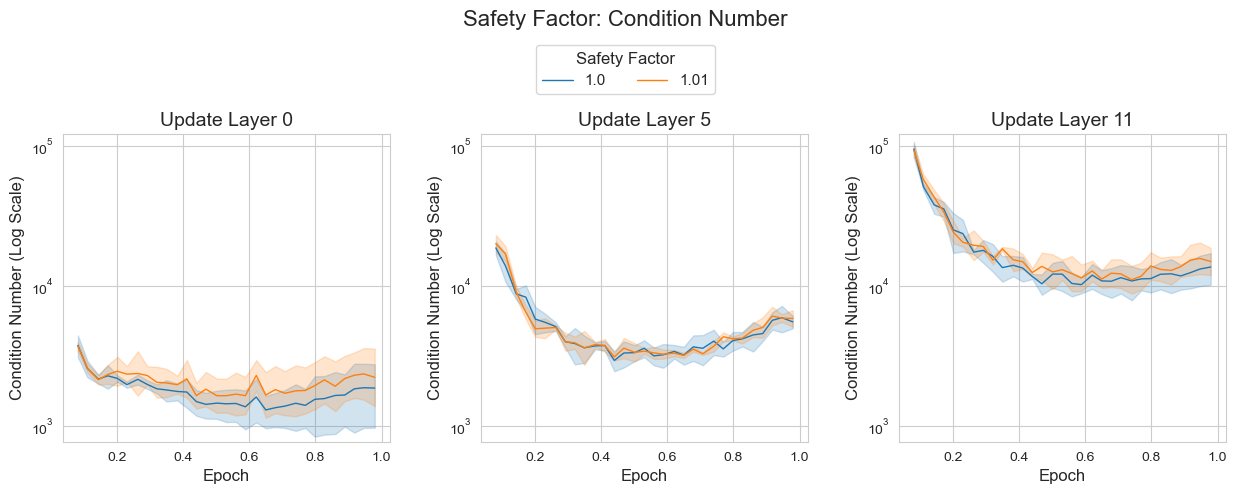

In [449]:
plot_data(
    df,
    x="step_norm",
    y_list=[
        "svd/update_layer0_stacked/condition_number",
        "svd/update_layer5_stacked/condition_number",
        "svd/update_layer11_stacked/condition_number",
    ],
    title_list=[
        "Update Layer 0",
        "Update Layer 5",
        "Update Layer 11",
    ],
    hue="config_optimizer_params.args.polar_safety",
    start=0.06,
    log_scale=True,
    save_plot=True,
)

In [450]:
def plot_data(df, x, y_list, title_list, hue, start=0, end=1000, \
              use_ci=False, log_scale=False, plot_med=True, save_plot=False):

    fig, axes = plt.subplots(1, len(y_list), figsize=(15, 4))
    
    for plt_idx, y in enumerate(y_list):
        
        if x != "_step":
            x_cols = df.columns.str.contains(x)
            print("Found x Columns:")
            for col in df.columns[x_cols]:
                print(col)
            assert sum(x_cols) == 1, "invalid number of columns found for x"
        
        y_cols = df.columns.str.contains(y)
        print("Found y Columns:")
        for col in df.columns[y_cols]:
            print(col)
        assert sum(y_cols) == 1, "invalid number of columns found for y"

        ylabels = ["Train Loss", "Val Loss"]
        
        print("Plotting Data...")
        sns.set_style("whitegrid")
        for val in df[hue].unique():
            df_grouped = df[df[hue] == val]
            df_clipped = df_grouped[(start <= df_grouped[x]) & (df_grouped[x] <= end)]
            ax_i = sns.lineplot(
                data=df_clipped,
                x=x,
                y=y,
                errorbar="sd",
                linestyle="-",
                linewidth=1,
                alpha=1,
                ax=axes[plt_idx],
                label=val if plt_idx == 0 else None
            )
    
            if log_scale:
                axes[plt_idx].set_yscale("log")

            # axes[plt_idx].set_title(title_list[plt_idx], fontsize=14)
            axes[plt_idx].set_xlabel("Epoch", fontsize=12)
            axes[plt_idx].set_ylabel(f"{ylabels[plt_idx]}", fontsize=12)
    
    fig.suptitle("Safety Factor: Loss (Epoch 0.95-1.00)", y=1.19, fontsize=16)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        title="Safety Factor",
        loc="upper center",
        ncol=len(labels),
        bbox_to_anchor=(0.5, 1.12),
        title_fontsize=12,
        fontsize=11,
    )

    EPS = 1e-8
    ymin = max(EPS, min(ax.get_ylim()[0] for ax in axes))
    ymax = max(ax.get_ylim()[1] for ax in axes)

    for ax in axes:
        ax.set_ylim(ymin, ymax)
        ax.tick_params(axis='both', labelsize=10)
        if ax.get_legend() is not None:
            ax.legend_.remove()
    
    if save_plot:
        print("Plot Saved.")
        plt.savefig(f"./plots/safety_factor_loss.jpg", bbox_inches='tight')
    
    plt.show();

Found x Columns:
step_norm
Found y Columns:
train/loss
Plotting Data...
Found x Columns:
step_norm
Found y Columns:
val/loss
Plotting Data...
Plot Saved.


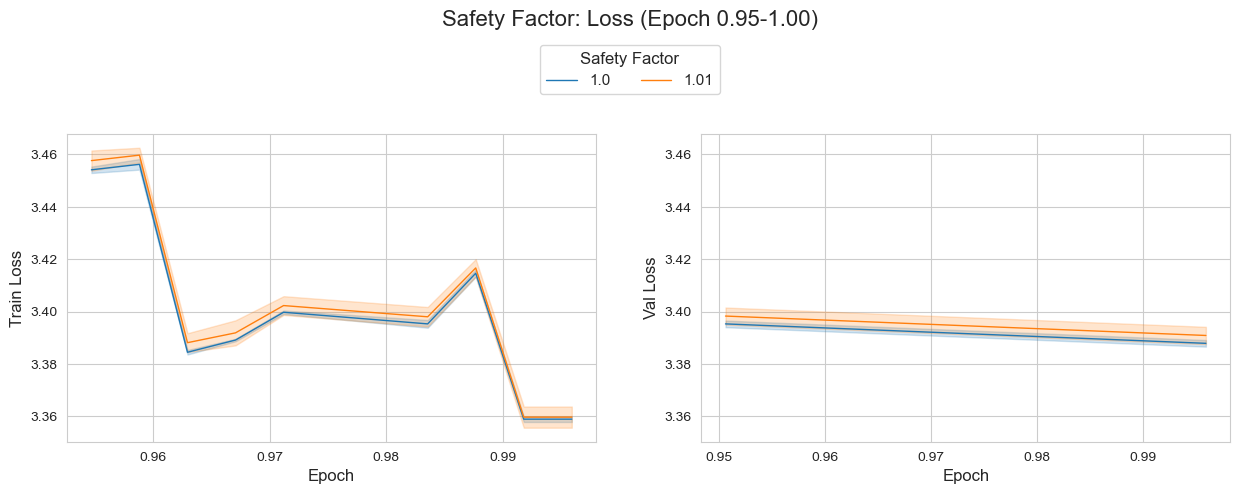

In [451]:
plot_data(
    df,
    x="step_norm",
    y_list=[
        "train/loss",
        "val/loss",
    ],
    title_list=[
        "Training Loss",
        "Validation Loss",
    ],
    hue="config_optimizer_params.args.polar_safety",
    start=0.95,
    log_scale=False,
    save_plot=True,
)

In [843]:
df = load_sweep_data("rs6k5h9h", manifest)
df["step_norm"] = df["_step"] / df["_step"].max()
for val in df['config_optimizer_params.args.polar_cushion'].unique():
    print(val)
for col in df.columns:
    print(col)
# x = 'diag_log_step'
# y = 'svd/layer11_q/condition_number'
# x_cols = df.columns.str.contains(x)
# print("Found x Columns:")
# for col in df.columns[x_cols]:
#     print("\t", col)

# y_cols = df.columns.str.contains(y)
# print("Found y Columns:")
# for col in df.columns[y_cols]:
#     print("\t", col)

# assert sum(x_cols) == 1, "invalid number of columns found for x"
# assert sum(y_cols) == 1, "invalid number of columns found for y"

Loading data for Sweep rs6k5h9h...
Loaded 2664 rows. Columns: 187
0.015
0.02
0.024
0.03
0.04
0.035
pe/ortho_err_after
svd_log/weights/layer5/q
logits/layer11/mean
attn/layer5/entropy/mean
svd/weights/layer0/stacked
ortho/layer0_k/err
ortho/layer11_v/err
svd_log/pre_update/layer11/k
svd/pre_update/layer0/q
logits/layer5/max_p95
svd_log/post_update/layer5/q
svd_log/post_update/layer0/q
svd/post_update/layer0/stacked
pe/ortho_err_before
train/naninf_flag
qkv/layer5/k_norm/mean
attn/layer5/entropy/p05
svd/pre_update/layer11/stacked
attn/layer0/entropy/p05
attn/layer11/maxA/frac>0.95
svd/weights/layer11/k
train/step_time_ms
svd_log/pre_update/layer0/q
svd_log/weights/layer5/k
svd/pre_update/layer11/k
svd/post_update/layer0/v
qkv/layer5/v_norm/mean
logits/layer0/max_p95
ortho/layer11_v/err_normalized
train/step
ortho/layer11_q/err_normalized
svd/post_update/layer11/k
ortho/layer0_q/err_normalized
svd/post_update/layer5/stacked
svd/weights/layer5/q
svd/post_update/layer5/k
svd/pre_update/laye

In [769]:
def plot_ortho_after_cushions_split(
    df,
    x="_step",
    start=0,
    end=1000,
    log_scale=False,
    save_plot=False,
):
    y = "pe/ortho_err_after"

    # All cushion values
    all_cushions = sorted(df["config_optimizer_params.args.polar_cushion"].dropna().unique())

    # Split cushions:
    include_c = 0.024
    cushions_left = all_cushions               # all cushions
    cushions_right = [c for c in all_cushions if c != include_c]  # exclude 0.024

    fig, axes = plt.subplots(1, 2, figsize=(13, 4), sharey=False)

    # -------------------------------------------------------------------------
    # LEFT SUBPLOT (all cushions)
    # -------------------------------------------------------------------------
    sns.set_style("whitegrid")

    for cval in cushions_left:
        mask = df["config_optimizer_params.args.polar_cushion"] == cval
        df_sub = df[mask]
        df_clipped = df_sub[(start <= df_sub[x]) & (df_sub[x] <= end)]

        sns.lineplot(
            data=df_clipped,
            x=x,
            y=y,
            errorbar="sd",
            linewidth=1,
            ax=axes[0],
            label=str(cval),
        )

    if log_scale:
        axes[0].set_yscale("log")

    axes[0].set_title("Post-Update Ortho Error (all cushions)", fontsize=14)
    axes[0].set_xlabel("Epoch", fontsize=12)
    axes[0].set_ylabel("Orthogonality Error", fontsize=12)


    # -------------------------------------------------------------------------
    # RIGHT SUBPLOT (all cushions EXCEPT 0.024)
    # -------------------------------------------------------------------------
    for cval in cushions_right:
        mask = df["config_optimizer_params.args.polar_cushion"] == cval
        df_sub = df[mask]
        df_clipped = df_sub[(start <= df_sub[x]) & (df_sub[x] <= end)]

        sns.lineplot(
            data=df_clipped,
            x=x,
            y=y,
            errorbar="sd",
            linewidth=1,
            ax=axes[1],
            label=str(cval),
        )

    if log_scale:
        axes[1].set_yscale("log")

    axes[1].set_title("Post-Update Ortho Error (c ≠ 0.024)", fontsize=14)
    axes[1].set_xlabel("Epoch", fontsize=12)
    axes[1].set_ylabel("Orthogonality Error", fontsize=12)


    # -------------------------------------------------------------------------
    # ZOOM RIGHT SUBPLOT based on cushions != 0.024
    # -------------------------------------------------------------------------
    df_zoom = df[df["config_optimizer_params.args.polar_cushion"].isin(cushions_right)]
    df_zoom = df_zoom[(start <= df_zoom[x]) & (df_zoom[x] <= end)]

    yvals = df_zoom[y].dropna()

    if len(yvals) > 0:
        y_low = yvals.min()
        y_high = yvals.max()
        padding = 0.05 * (y_high - y_low + 1e-8)
        axes[1].set_ylim(y_low - padding, y_high + padding)


    # -------------------------------------------------------------------------
    # Style, legend, finalize
    # -------------------------------------------------------------------------
    for ax in axes:
        ax.tick_params(axis="both", labelsize=10)

    fig.suptitle("PE Orthogonality Error vs Cushion (Post-Update)",
                 y=1.19, fontsize=16)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        title="Cushion",
        loc="upper center",
        ncol=len(labels),
        bbox_to_anchor=(0.5, 1.12),
        title_fontsize=12,
        fontsize=11,
    )

    # Remove subplot legends
    for ax in axes:
        if ax.get_legend() is not None:
            ax.get_legend().remove()

    fig.subplots_adjust(wspace=0.15)

    if save_plot:
        plt.savefig("./plots/ortho_after_split_cushions.jpg", bbox_inches="tight")

    plt.show()

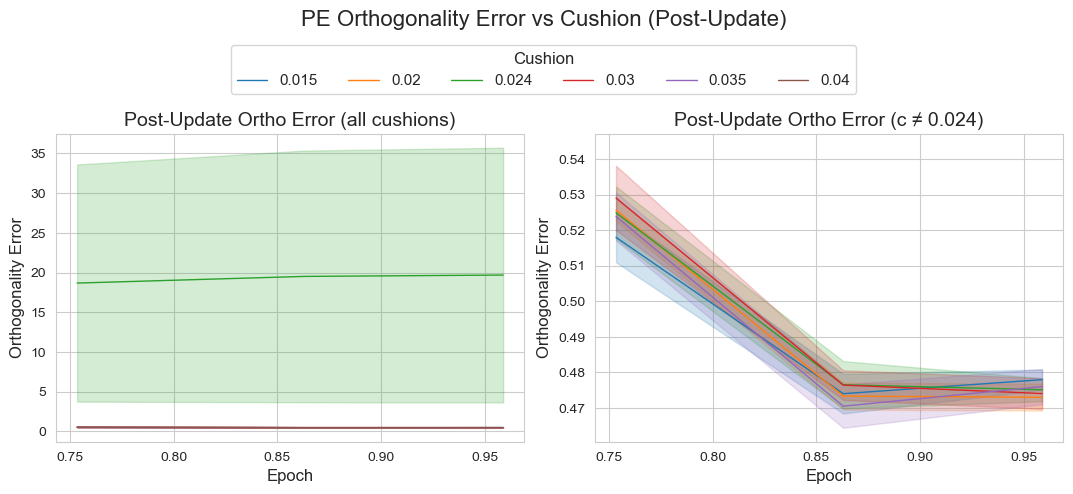

In [770]:
plot_ortho_after_cushions_split(df, x="step_norm", start=0.7, end=1000, log_scale=False, save_plot=True)

In [803]:
def plot_loss_and_ortho_selected(
    df,
    x="_step",
    start_left=0,
    start_right=0,
    end=1000,
    log_scale=False,
    save_plot=False,
):
    y_left  = "train/loss"          # train loss column
    y_right = "pe/ortho_err_after"  # post-update orthogonality error

    num_col = "config_optimizer_params.args.polar_num_iters"
    c_col   = "config_optimizer_params.args.polar_cushion"

    # Two specific (num_iters, cushion) settings
    configs = [
        ("T = 5, c = 0.024", "[5]", 0.024),
        ("T = 3, c = 0.04",  "[3]", 0.04),
    ]

    fig, axes = plt.subplots(1, 2, figsize=(13, 4), sharey=False)
    sns.set_style("whitegrid")

    # -------------------------------------------------------------------------
    # LEFT: train loss
    # -------------------------------------------------------------------------
    for label, num_val, c_val in configs:
        mask = (df[num_col] == num_val) & (df[c_col] == c_val)
        df_sub = df[mask]

        df_clipped = df_sub[(start_left <= df_sub[x]) & (df_sub[x] <= end)]

        sns.lineplot(
            data=df_clipped,
            x=x,
            y=y_left,
            errorbar="sd",
            linewidth=1,
            ax=axes[0],
            label=label,
        )

    if log_scale:
        axes[0].set_yscale("log")

    axes[0].set_title("Train Loss (Epochs 0.75-1.00)", fontsize=14)
    axes[0].set_xlabel("Epoch", fontsize=12)
    axes[0].set_ylabel("Train Loss", fontsize=12)

    # -------------------------------------------------------------------------
    # RIGHT: post-update orthogonality error
    # -------------------------------------------------------------------------
    for label, num_val, c_val in configs:
        mask = (df[num_col] == num_val) & (df[c_col] == c_val)
        df_sub = df[mask]

        df_clipped = df_sub[(start_right <= df_sub[x]) & (df_sub[x] <= end)]

        sns.lineplot(
            data=df_clipped,
            x=x,
            y=y_right,
            errorbar="sd",
            linewidth=1,
            ax=axes[1],
            label=label,
        )

    if log_scale:
        axes[1].set_yscale("log")

    axes[1].set_title("Post-Update Ortho Error (Full Run)", fontsize=14)
    axes[1].set_xlabel("Epoch", fontsize=12)
    axes[1].set_ylabel("Orthogonality Error", fontsize=12)

    # -------------------------------------------------------------------------
    # Style, legend, finalize
    # -------------------------------------------------------------------------
    for ax in axes:
        ax.tick_params(axis="both", labelsize=10)

    fig.suptitle("Selected Runs: Loss and Post-Update Ortho Error",
                 y=1.19, fontsize=16)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        title="Setting",
        loc="upper center",
        ncol=len(labels),
        bbox_to_anchor=(0.5, 1.12),
        title_fontsize=12,
        fontsize=11,
    )

    # Remove per-axes legends
    for ax in axes:
        if ax.get_legend() is not None:
            ax.get_legend().remove()

    fig.subplots_adjust(wspace=0.15)

    if save_plot:
        plt.savefig("./plots/loss_and_ortho_selected.jpg", bbox_inches="tight")

    plt.show()

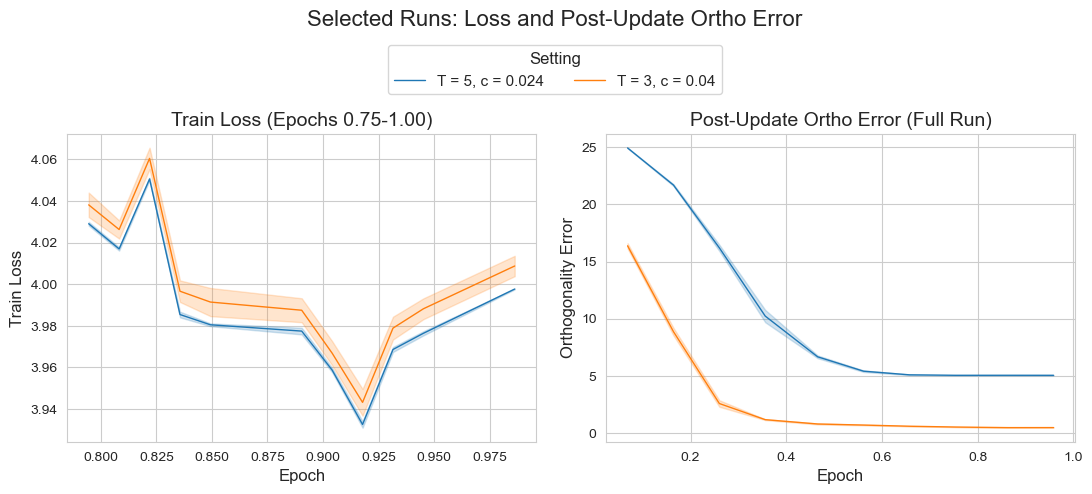

In [805]:
plot_loss_and_ortho_selected(df, x="step_norm", start_left=0.75, start_right=0, log_scale=False, save_plot=True)

In [706]:
def plot_data_filtered(
    df,
    x,
    y_list,
    title_list,
    filters,            # NEW: list of dicts defining each subplot's filter
    start=0,
    end=1000,
    use_ci=False,
    log_scale=False,
    plot_med=True,
    save_plot=False,
):

    assert len(filters) == len(y_list) == len(title_list), \
        "filters, y_list, and title_list must have the same length"

    fig, axes = plt.subplots(1, len(y_list), figsize=(15, 4), sharey=False)

    for plt_idx, (y, flt) in enumerate(zip(y_list, filters)):

        # Apply filter (e.g., num_iters=3 & cushion=0.04)
        df_sub = df.copy()
        for key, val in flt.items():
            df_sub = df_sub[df_sub[key] == val]

        # Clip by step range
        df_clipped = df_sub[(start <= df_sub[x]) & (df_sub[x] <= end)]

        print(f"Plotting {title_list[plt_idx]} with filter:", flt)
        sns.set_style("whitegrid")

        sns.lineplot(
            data=df_clipped,
            x=x,
            y=y,
            errorbar="sd",
            linestyle="-",
            linewidth=1,
            alpha=1,
            ax=axes[plt_idx],
        )

        if log_scale:
            axes[plt_idx].set_yscale("log")

        axes[plt_idx].set_title(title_list[plt_idx], fontsize=14)
        axes[plt_idx].set_xlabel("Epoch", fontsize=12)
        axes[plt_idx].set_ylabel("Orthogonality Error", fontsize=12)

    fig.suptitle("Selected Runs: Orthogonality Error", y=1.15, fontsize=16)

    # unify y-limits
    EPS = 1e-8
    ymin = max(EPS, min(ax.get_ylim()[0] for ax in axes))
    ymax = max(ax.get_ylim()[1] for ax in axes)
    for ax in axes:
        ax.set_ylim(ymin, ymax)
        ax.tick_params(axis='both', labelsize=10)

    fig.subplots_adjust(wspace=0.3)

    if save_plot:
        plt.savefig("./plots/cushion_ortho_selected.jpg", bbox_inches='tight')

    plt.show()

Plotting Num Iters = 3, Cushion = 0.04 with filter: {'config_optimizer_params.args.polar_num_iters': '[3]', 'config_optimizer_params.args.polar_cushion': 0.04}
Plotting Num Iters = 5, Cushion = 0.024 with filter: {'config_optimizer_params.args.polar_num_iters': '[5]', 'config_optimizer_params.args.polar_cushion': 0.024}


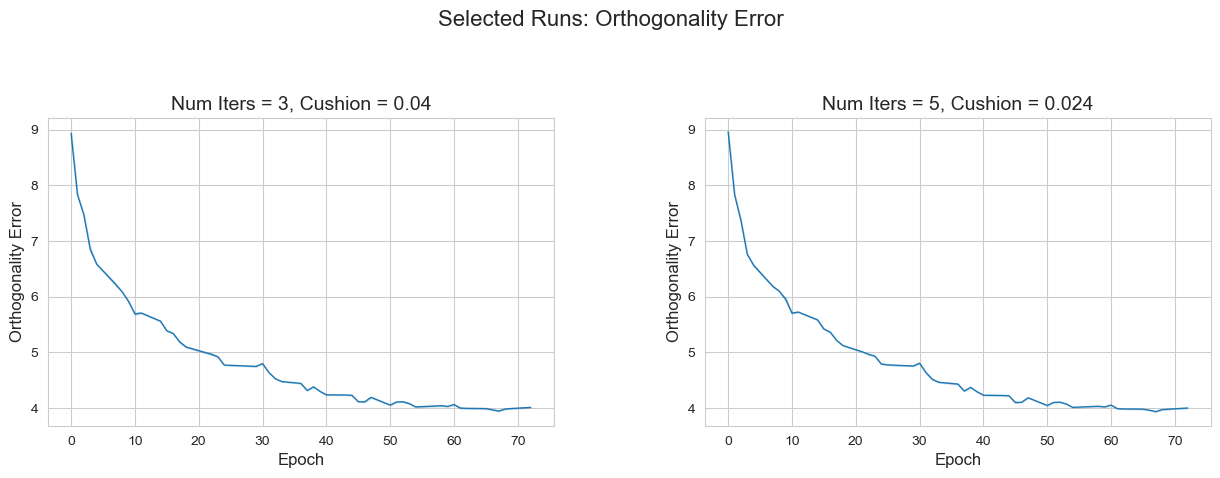

In [709]:
plot_data_filtered(
    df=df,
    x="_step",
    y_list=[
        "train/loss",
        "train/loss",
    ],   # same metric for both subplots
    title_list=[
        "Num Iters = 3, Cushion = 0.04",
        "Num Iters = 5, Cushion = 0.024",
    ],
    filters=[
        {"config_optimizer_params.args.polar_num_iters": "[3]", "config_optimizer_params.args.polar_cushion": 0.04},
        {"config_optimizer_params.args.polar_num_iters": "[5]", "config_optimizer_params.args.polar_cushion": 0.024},
    ],
    log_scale=False,
    save_plot=False
)

In [847]:
import ast
import numpy as np
import matplotlib.pyplot as plt

def plot_svd_specific_configs(
    df,
    svd_col,
    num_iters_col,
    cushion_col,
    step_col="step_norm",
    left_config=("[5]", 0.024),
    right_config=("[3]", 0.04),
    title_left="T = 5, c = 0.024",
    title_right="T = 3, c = 0.04",
    log_density=False,
    figsize=(14, 4),
    save_plot=False
):
    df_sorted = df.sort_values(step_col).reset_index(drop=True)

    panels = [
        (*left_config, title_left),
        (*right_config, title_right),
    ]

    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)

    # Load binning info from first non-null SVD entry
    first_series = df_sorted[svd_col].dropna()
    if first_series.empty:
        raise ValueError(f"No non-null data in {svd_col}")

    first_hist = ast.literal_eval(first_series.iloc[0])
    bins_info = first_hist["packedBins"]

    n_bins = bins_info["count"]
    bin_min = bins_info["min"]
    bin_size = bins_info["size"]
    bin_centers = bin_min + bin_size * (np.arange(n_bins) + 0.5)

    all_steps = df_sorted[step_col].dropna().to_numpy()
    x_min, x_max = all_steps.min(), all_steps.max()

    # white for low density, dark for high
    cmap = plt.cm.Blues
    cmap = cmap.copy()
    cmap.set_under("white")

    im = None

    for ax, (num_val, cushion_val, title) in zip(axes, panels):

        df_sel = df_sorted[
            (df_sorted[num_iters_col] == num_val) &
            (df_sorted[cushion_col] == cushion_val)
        ]

        valid_rows = df_sel[df_sel[svd_col].notna()]

        if valid_rows.empty:
            ax.set_title(title + " (no SVD data)")
            ax.set_xlabel("Epoch")
            continue

        steps = valid_rows[step_col].to_numpy()
        H = np.zeros((len(steps), n_bins), dtype=float)

        for i, s in enumerate(valid_rows[svd_col]):
            h = ast.literal_eval(s)
            vals = np.array(h["values"], dtype=float)

            if len(vals) > n_bins:
                vals = vals[:n_bins]
            elif len(vals) < n_bins:
                vals = np.pad(vals, (0, n_bins - len(vals)))

            H[i] = vals

        # ------------------------------------------------------
        # Convert histograms to DENSITY
        # ------------------------------------------------------
        row_sum = H.sum(axis=1, keepdims=True)
        H = H / np.maximum(row_sum, 1e-12)

        H_plot = np.log1p(H) if log_density else H

        im = ax.imshow(
            H_plot.T,
            origin="lower",
            aspect="auto",
            extent=[x_min, x_max, bin_centers.min(), bin_centers.max()],
            cmap=cmap,
            vmin=1e-12,
        )

        ax.set_title(title, fontsize=14)
        ax.set_xlabel("Epoch", fontsize=12)
        ax.set_ylabel("Singular Value (Log Scale)", fontsize=12)
        ax.tick_params(axis='both', labelsize=10)

    fig.suptitle("Singular Value Density for Selected (T, c)",
                 x=0.45, y=1.07, fontsize=16)

    axes[1].tick_params(labelleft=True, left=True)
    axes[1].set_ylabel("Singular Value (Log Scale)", fontsize=12)

    # Shared colorbar
    if im is not None:
        cbar = fig.colorbar(im, ax=axes, shrink=0.9)
        cbar.set_label("log(1 + density)" if log_density else "Density", fontsize=11)

    if save_plot:
        plt.savefig("./plots/svd_specific_configs_density.jpg", bbox_inches="tight")

    plt.show()

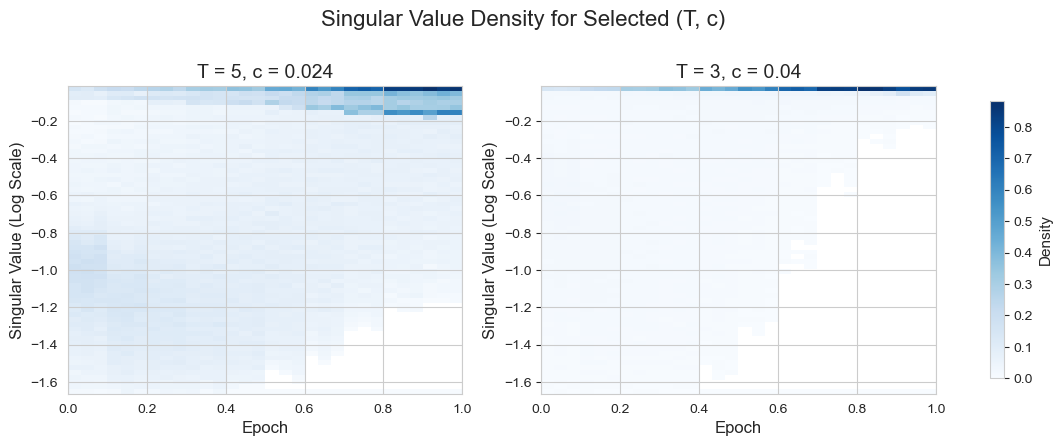

In [848]:
plot_svd_specific_configs(
    df,
    svd_col="svd_log/post_update/layer11/stacked",
    num_iters_col="config_optimizer_params.args.polar_num_iters",
    cushion_col="config_optimizer_params.args.polar_cushion",
    save_plot=True
)

In [838]:
df = load_sweep_data("j7qzf95f", manifest)
df["step_norm"] = df["_step"] / df["_step"].max()
for val in df['config_optimizer_params.args.polar_cushion'].unique():
    print(val)
for col in df.columns:
    print(col)
# x = 'diag_log_step'
# y = 'svd/layer11_q/condition_number'
# x_cols = df.columns.str.contains(x)
# print("Found x Columns:")
# for col in df.columns[x_cols]:
#     print("\t", col)

# y_cols = df.columns.str.contains(y)
# print("Found y Columns:")
# for col in df.columns[y_cols]:
#     print("\t", col)

# assert sum(x_cols) == 1, "invalid number of columns found for x"
# assert sum(y_cols) == 1, "invalid number of columns found for y"

Loading data for Sweep j7qzf95f...
Loaded 11468 rows. Columns: 187
0.024
svd_log/pre_update/layer11/stacked
qkv/layer0/k_norm/mean
logits/layer11/std
svd/pre_update/layer0/stacked
ortho/layer5_q/err
logits/layer11/max_p95
train/tokens_per_sec
ortho/layer11_q/err_normalized
svd/post_update/layer5/stacked
qkv/layer5/k_norm/mean
_runtime
qkv/layer5/q_norm/mean
svd/weights/layer5/stacked
attn/layer11/entropy/mean
svd_log/post_update/layer5/k
ortho/layer0_k/err
svd_log/pre_update/layer5/stacked
attn/layer11/entropy/p05
attn/layer11/entropy/p95
svd/post_update/layer11/q
qkv/layer5/v_norm/mean
svd_log/post_update/layer11/v
pe/ortho_err_after
ortho/layer11_k/err_normalized
qkv/layer0/v_norm/mean
val/ppl
train/total_time_seconds
svd/post_update/layer0/v
svd_log/post_update/layer5/q
svd/total_time_ms
logits/layer5/mean
ortho/layer0_q/err
svd/pre_update/layer11/v
svd/weights/layer5/v
attn/layer0/entropy/mean
val/loss
pe/ortho_err_before
ortho/layer0_v/err_normalized
svd_log/pre_update/layer11/q
l

In [502]:
def plot_data(df, x, y_list, title_list, hue, start=0, end=1000, \
              use_ci=False, log_scale=False, plot_med=True, save_plot=False):

    fig, axes = plt.subplots(1, len(y_list), figsize=(15, 4))
    
    for plt_idx, y in enumerate(y_list):
        
        if x != "_step":
            x_cols = df.columns.str.contains(x)
            print("Found x Columns:")
            for col in df.columns[x_cols]:
                print(col)
            assert sum(x_cols) == 1, "invalid number of columns found for x"
        
        y_cols = df.columns.str.contains(y)
        print("Found y Columns:")
        for col in df.columns[y_cols]:
            print(col)
        assert sum(y_cols) == 1, "invalid number of columns found for y"

        ylabels = ["Train Loss", "Val Loss"]
        
        print("Plotting Data...")
        sns.set_style("whitegrid")
        hue_list = ["[3]", "[4]", "[5]", "[6]", "[7]",]
        for val in hue_list:
            df_grouped = df[df[hue] == val]
            df_clipped = df_grouped[(start <= df_grouped[x]) & (df_grouped[x] <= end)]
            ax_i = sns.lineplot(
                data=df_clipped,
                x=x,
                y=y,
                errorbar="sd",
                linestyle="-",
                linewidth=1,
                alpha=1,
                ax=axes[plt_idx],
                label=val.replace("[", "").replace("]", "") if plt_idx == 0 else None
            )
    
            if log_scale:
                axes[plt_idx].set_yscale("log")

            # axes[plt_idx].set_title(title_list[plt_idx], fontsize=14)
            axes[plt_idx].set_xlabel("Epoch", fontsize=12)
            axes[plt_idx].set_ylabel(f"{ylabels[plt_idx]}", fontsize=12)
    
    fig.suptitle("Num Iters: Loss (Epoch 0.95-1.00)", y=1.19, fontsize=16)

    handles, labels = axes[0].get_legend_handles_labels()
    leg = fig.legend(
        handles,
        labels,
        title="Num Iters",
        loc="upper center",
        ncol=5,
        bbox_to_anchor=(0.5, 1.12),
        title_fontsize=12,
        fontsize=11,
    )

    EPS = 1e-8
    ymin = max(EPS, min(ax.get_ylim()[0] for ax in axes))
    ymax = max(ax.get_ylim()[1] for ax in axes)

    for ax in axes:
        ax.set_ylim(ymin, ymax)
        ax.tick_params(axis='both', labelsize=10)
        if ax.get_legend() is not None:
            ax.legend_.remove()
    
    if save_plot:
        print("Plot Saved.")
        plt.savefig(f"./plots/num_iters_loss.jpg", bbox_inches='tight')
    
    plt.show();

Found x Columns:
step_norm
Found y Columns:
train/loss
Plotting Data...
Found x Columns:
step_norm
Found y Columns:
val/loss
Plotting Data...
Plot Saved.


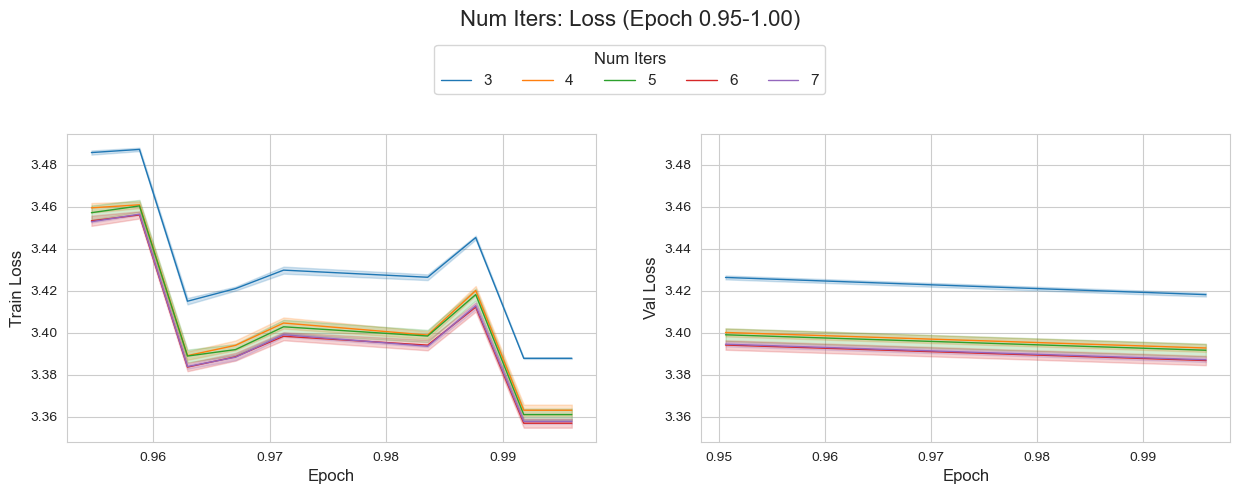

In [503]:
plot_data(
    df,
    x="step_norm",
    y_list=[
        "train/loss",
        "val/loss",
    ],
    title_list=[
        "Training Loss",
        "Validation Loss",
    ],
    hue="config_optimizer_params.args.polar_num_iters",
    start=0.95,
    log_scale=False,
    save_plot=True,
)

In [630]:
import ast
import numpy as np
import matplotlib.pyplot as plt

def plot_svd_cushion_heatmaps(
    df,
    svd_col,                 # e.g. 'svd_log/post_update/layer11/k'
    cushion_col,             # e.g. 'config/cushion'
    step_col="step_norm",
    cushion_vals=None,
    title_list=None,
    log_counts=False,
    figsize=(15, 4),
    save_plot=False,
):
    # Sort once
    df_sorted = df.sort_values(step_col).reset_index(drop=True)

    # Which cushions to plot
    if cushion_vals is None:
        cushion_vals = sorted(df_sorted[cushion_col].dropna().unique())

    n_panels = len(cushion_vals)

    if title_list is None:
        title_list = [f"{cushion_col} = {val}" for val in cushion_vals]

    fig, axes = plt.subplots(1, n_panels, figsize=figsize, sharey=True)
    if n_panels == 1:
        axes = [axes]

    # Set up colormap: white for zero, dark blue for high density
    cmap = plt.cm.Blues
    cmap = cmap.copy()
    cmap.set_under("white")

    # Get binning from first non-null SVD entry
    first_series = df_sorted[svd_col].dropna()
    if first_series.empty:
        raise ValueError(f"No non-null data in {svd_col}")
    first_hist = ast.literal_eval(first_series.iloc[0])
    bins_info = first_hist["packedBins"]

    n_bins = bins_info["count"]
    bin_min = bins_info["min"]
    bin_size = bins_info["size"]
    bin_centers = bin_min + bin_size * (np.arange(n_bins) + 0.5)

    # Global x-extent for all panels
    all_steps = df_sorted[step_col].dropna().to_numpy()
    x_min, x_max = all_steps.min(), all_steps.max()

    im = None

    for ax, cushion, title in zip(axes, cushion_vals, title_list):
        # Filter by cushion
        df_c = df_sorted[df_sorted[cushion_col] == cushion]

        # Keep only rows where SVD is logged
        valid_rows = df_c[df_c[svd_col].notna()]

        if valid_rows.empty:
            ax.set_title(title + " (no SVD data)")
            ax.set_xlabel("Step")
            continue

        steps = valid_rows[step_col].to_numpy()

        # Build [num_steps, num_bins] matrix of counts
        H = np.zeros((len(valid_rows), n_bins), dtype=float)
        for i, s in enumerate(valid_rows[svd_col]):
            h = ast.literal_eval(s)
            vals = np.array(h["values"], dtype=float)

            # Defensive padding/truncation
            if len(vals) > n_bins:
                vals = vals[:n_bins]
            elif len(vals) < n_bins:
                vals = np.pad(vals, (0, n_bins - len(vals)))

            H[i] = vals

        H_plot = np.log1p(H) if log_counts else H

        im = ax.imshow(
            H_plot.T,
            origin="lower",
            aspect="auto",
            extent=[x_min, x_max, bin_centers.min(), bin_centers.max()],
            cmap=cmap,
            vmin=1e-12,
        )

        ax.set_title(title, fontsize=12)
        ax.set_xlabel("Epoch", fontsize=11)
        ax.set_ylabel("Singular Value (Log Scale)", fontsize=11)
        ax.tick_params(axis='y', labelleft=True)

    fig.suptitle("Num Iters: Singular Value Distribution", x=0.45, y=1.05, fontsize=16)

    # Shared colorbar
    if im is not None:
        cbar = fig.colorbar(im, ax=axes, shrink=0.9)
        cbar.set_label("Count (Log Scale)" if log_counts else "Count", fontsize=11)

    if save_plot:
        print("Plot Saved.")
        plt.savefig(f"./plots/num_iters_svd.jpg", bbox_inches='tight')

    plt.show()

Plot Saved.


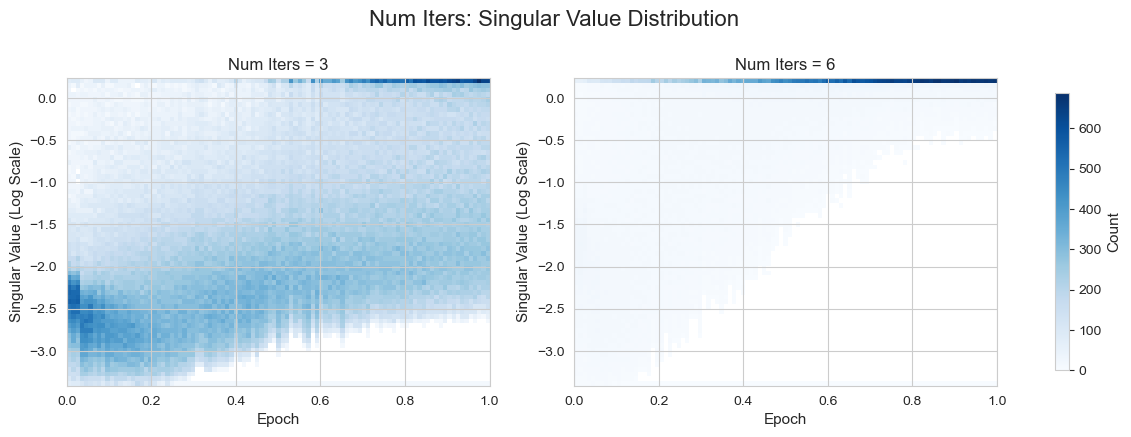

In [632]:
plot_svd_cushion_heatmaps(
    df,
    svd_col="svd_log/post_update/layer11/stacked",
    cushion_col="config_optimizer_params.args.polar_num_iters",
    cushion_vals=["[3]", "[6]"],
    title_list=["Num Iters = 3", "Num Iters = 6"],
    log_counts=False,   # or True if you prefer
    figsize=(15, 4),
    save_plot=True,
)

In [840]:
import ast
import numpy as np
import matplotlib.pyplot as plt

def plot_svd_cushion_heatmaps(
    df,
    svd_col_top,             # e.g. 'svd_log/pre_update/layer11/k'
    svd_col_bottom,          # e.g. 'svd_log/post_update/layer11/k'
    cushion_col,             # e.g. 'config/cushion'
    step_col="step_norm",
    cushion_vals=None,
    title_list=None,
    log_counts=False,        # if True: log(1 + value) for color
    use_density=False,       # NEW: if True, normalize each row to sum to 1
    figsize=(12, 10),
    save_plot=False,
):
    # Sort once
    df_sorted = df.sort_values(step_col).reset_index(drop=True)

    # Which cushions to plot
    if cushion_vals is None:
        cushion_vals = sorted(df_sorted[cushion_col].dropna().unique())

    if len(cushion_vals) != 2:
        raise ValueError(
            f"This function expects exactly two cushion values for a 2x2 grid; got {len(cushion_vals)}."
        )

    n_cols = 2

    if title_list is None:
        title_list = [f"{cushion_col} = {val}" for val in cushion_vals]

    fig, axes = plt.subplots(
        2, n_cols, figsize=figsize, sharex=True, sharey=True
    )

    from matplotlib.colors import LinearSegmentedColormap

    # Custom colormap: white → blue → purple → red
    cmap = LinearSegmentedColormap.from_list(
        "white_blue_purple_red",
        [
            (0.00, "white"),
            (0.20, "blue"),
            (0.60, "purple"),
            (1.00, "red"),
        ]
    )
    cmap = cmap.copy()
    cmap.set_under("white")

    # Get binning from first non-null SVD entry in the top column
    first_series = df_sorted[svd_col_top].dropna()
    if first_series.empty:
        raise ValueError(f"No non-null data in {svd_col_top}")
    first_hist = ast.literal_eval(first_series.iloc[0])
    bins_info = first_hist["packedBins"]

    n_bins = bins_info["count"]
    bin_min = bins_info["min"]
    bin_size = bins_info["size"]
    bin_centers = bin_min + bin_size * (np.arange(n_bins) + 0.5)

    # Global x-extent for all panels
    all_steps = df_sorted[step_col].dropna().to_numpy()
    x_min, x_max = all_steps.min(), all_steps.max()

    ims_top = []
    ims_bottom = []

    def plot_one_row(ax_row, svd_col, row_idx, im_list):
        for col_idx, (ax, cushion, title) in enumerate(zip(ax_row, cushion_vals, title_list)):
            # Filter by cushion
            df_c = df_sorted[df_sorted[cushion_col] == cushion]

            # Keep only rows where SVD is logged
            valid_rows = df_c[df_c[svd_col].notna()]

            if valid_rows.empty:
                ax.set_title(title + " (no SVD data)")
                if row_idx == 1:
                    ax.set_xlabel("Epoch", fontsize=11)
                if col_idx == 0:
                    ax.set_ylabel("Singular Value (Log Scale)", fontsize=11)
                continue

            steps = valid_rows[step_col].to_numpy()

            # Build [num_steps, num_bins] matrix of counts
            H = np.zeros((len(valid_rows), n_bins), dtype=float)
            for i, s in enumerate(valid_rows[svd_col]):
                h = ast.literal_eval(s)
                vals = np.array(h["values"], dtype=float)

                # Defensive padding/truncation
                if len(vals) > n_bins:
                    vals = vals[:n_bins]
                elif len(vals) < n_bins:
                    vals = np.pad(vals, (0, n_bins - len(vals)))

                H[i] = vals

            # ---- NEW: convert to density, if requested ----
            if use_density:
                row_sum = H.sum(axis=1, keepdims=True)
                H = H / np.maximum(row_sum, 1e-12)

            H_plot = np.log1p(H) if log_counts else H

            im = ax.imshow(
                H_plot.T,
                origin="lower",
                aspect="auto",
                extent=[x_min, x_max, bin_centers.min(), bin_centers.max()],
                cmap=cmap,
                vmin=1e-12,
            )
            im_list.append(im)

            if row_idx == 0:
                ax.set_title(f"{title}", fontsize=12)

            # X-label only on bottom row
            if row_idx == 1:
                ax.set_xlabel("Epoch", fontsize=11)

            # Y-label only on left column
            if col_idx == 0:
                if row_idx == 0:
                    ax.set_ylabel("Pre-Update\nSingular Value (Log Scale)", fontsize=11)
                else:
                    ax.set_ylabel("Post-Update\nSingular Value (Log Scale)", fontsize=11)

            ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=True)

    # Top row: svd_col_top
    plot_one_row(axes[0, :], svd_col_top, row_idx=0, im_list=ims_top)
    # Bottom row: svd_col_bottom
    plot_one_row(axes[1, :], svd_col_bottom, row_idx=1, im_list=ims_bottom)

    # Layout before colorbars
    fig.tight_layout(rect=[0, 0, 1, 0.93])

    # Decide colorbar label based on mode
    if use_density:
        cbar_label = "Density (Log Scale)" if log_counts else "Density"
    else:
        cbar_label = "Count (Log Scale)" if log_counts else "Count"

    # Normalize and add separate colorbars for each row
    if ims_top:
        vmax_top = max(im.get_array().max() for im in ims_top)
        for im in ims_top:
            im.set_clim(vmin=1e-12, vmax=vmax_top)
        cbar_top = fig.colorbar(ims_top[-1], ax=axes[0, :], shrink=0.9)
        cbar_top.set_label(cbar_label, fontsize=11)

    if ims_bottom:
        vmax_bot = max(im.get_array().max() for im in ims_bottom)
        for im in ims_bottom:
            im.set_clim(vmin=1e-12, vmax=vmax_bot)
        cbar_bot = fig.colorbar(ims_bottom[-1], ax=axes[1, :], shrink=0.9)
        cbar_bot.set_label(cbar_label, fontsize=11)

    fig.suptitle(
        "Num Iters: Singular Value " + ("Density" if use_density else "Distribution"),
        x=0.45,
        y=0.96,
        fontsize=16,
    )

    if save_plot:
        print("Plot Saved.")
        plt.savefig(f"./plots/num_iters_svd.jpg", bbox_inches='tight')

    plt.show()

Plot Saved.


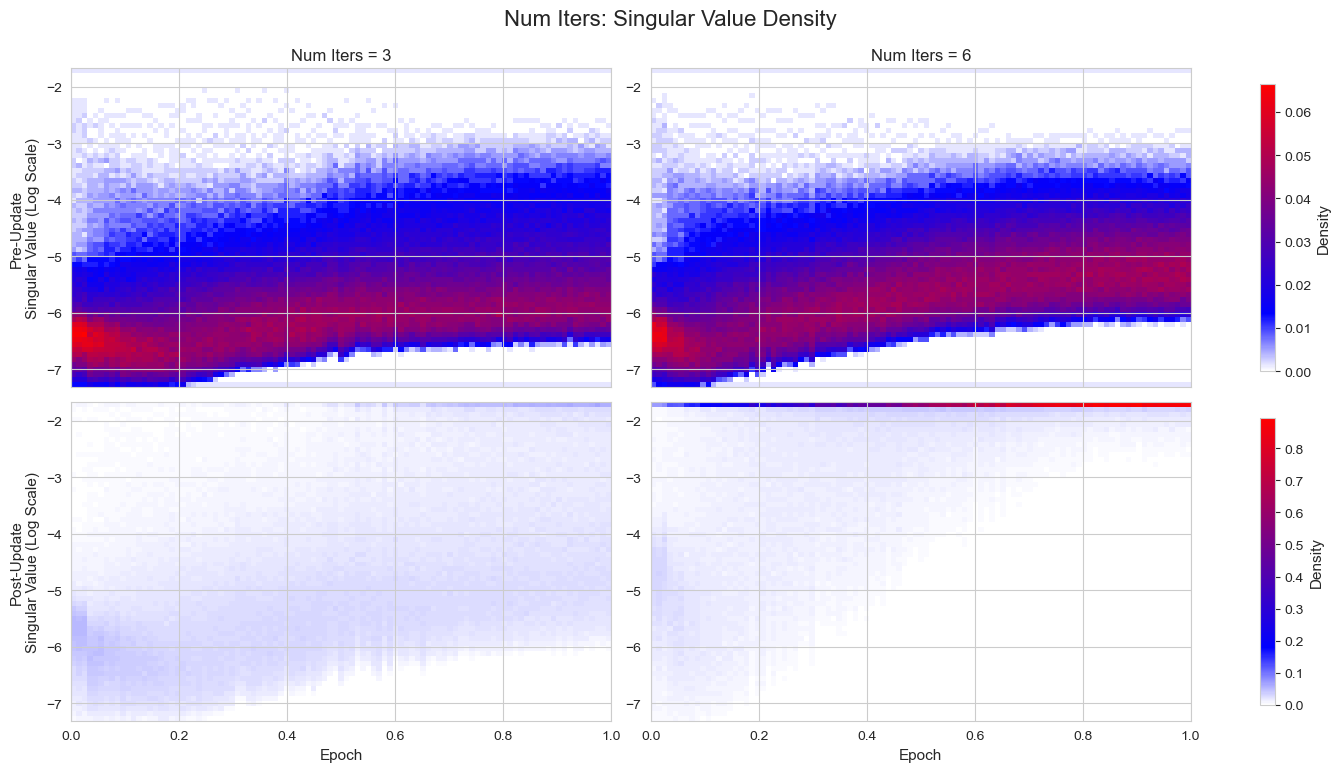

In [842]:
plot_svd_cushion_heatmaps(
    df,
    svd_col_top="svd_log/pre_update/layer11/stacked",
    svd_col_bottom="svd_log/post_update/layer11/stacked",
    cushion_col="config_optimizer_params.args.polar_num_iters",  # grouping key
    cushion_vals=["[3]", "[6]"],                                 # 3 vs 6 iters
    title_list=["Num Iters = 3", "Num Iters = 6"],
    log_counts=False,     # or True for log(1 + density)
    use_density=True,     # <<< this is the new part
    figsize=(15, 8),
    save_plot=True,
)